In [2]:
import pandas as pd
import numpy as np
import torch
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
import shap
import matplotlib.pyplot as plt
import warnings
import os
warnings.filterwarnings('ignore')

print("="*80)
print("🔍 SHAP EXPLAINABILITY ANALYSIS")
print("="*80)

# First, let's find where your model actually is
print("\n🔍 Searching for model files...")

# Check possible locations
possible_paths = [
    '../models/xlm-roberta-fakenews-final',
    '../models/trained_model/xlm-roberta-fakenews-final',
    'models/xlm-roberta-fakenews-final',
    'models/trained_model/xlm-roberta-fakenews-final',
]

model_path = None
for path in possible_paths:
    if os.path.exists(path):
        model_path = path
        print(f"✓ Found model at: {path}")
        break

if model_path is None:
    print("❌ Model not found in expected locations!")
    print("\nPlease check your folder structure. The model should be at:")
    print("  Multilingual_Misinformation_Detection/")
    print("    └── models/")
    print("        └── xlm-roberta-fakenews-final/")
    print("            ├── config.json")
    print("            ├── pytorch_model.bin (or model.safetensors)")
    print("            └── tokenizer files...")
    
    # Let's check what's actually in the models folder
    print("\n📁 Contents of models folder:")
    models_dir = '../models' if os.path.exists('../models') else 'models'
    if os.path.exists(models_dir):
        for item in os.listdir(models_dir):
            print(f"  - {item}")
            item_path = os.path.join(models_dir, item)
            if os.path.isdir(item_path):
                print(f"    Contents:")
                for subitem in os.listdir(item_path):
                    print(f"      - {subitem}")
    else:
        print("  ❌ Models folder not found!")
    
    raise FileNotFoundError("Model not found. Please check the path.")

# Load the model
print(f"\n📥 Loading trained model from: {model_path}")

try:
    tokenizer = XLMRobertaTokenizer.from_pretrained(model_path)
    model = XLMRobertaForSequenceClassification.from_pretrained(model_path)
    model.eval()
    
    print("✓ Model loaded successfully!")
    print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
    
except Exception as e:
    print(f"❌ Error loading model: {str(e)}")
    print("\n💡 Troubleshooting:")
    print("1. Make sure you downloaded the model from Google Colab")
    print("2. The model folder should contain these files:")
    print("   - config.json")
    print("   - pytorch_model.bin or model.safetensors")
    print("   - tokenizer.json")
    print("   - special_tokens_map.json")
    print("   - tokenizer_config.json")
    raise

# Load test data
print("\n📂 Loading test data...")
test_df = pd.read_csv('../data/processed/multilingual_combined.csv')
print(f"✓ Loaded {len(test_df)} test samples")


🔍 SHAP EXPLAINABILITY ANALYSIS

🔍 Searching for model files...
✓ Found model at: ../models/trained_model/xlm-roberta-fakenews-final

📥 Loading trained model from: ../models/trained_model/xlm-roberta-fakenews-final
✓ Model loaded successfully!
Device: CPU

📂 Loading test data...
✓ Loaded 21414 test samples


In [3]:
print("\n" + "="*80)
print("⚙️ SETTING UP SHAP EXPLAINER")
print("="*80)

# Prediction function that SHAP can use
def predict_proba(texts):
    """
    Prediction function for SHAP
    Returns probabilities for [Real, Fake]
    """
    if isinstance(texts, str):
        texts = [texts]
    
    inputs = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=256
    )
    
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    return probs.cpu().numpy()

# Test the function
test_text = "This is a test news article."
test_probs = predict_proba(test_text)
print(f"\n✓ Prediction function working!")
print(f"  Test prediction: Real={test_probs[0][0]:.3f}, Fake={test_probs[0][1]:.3f}")

# Initialize SHAP explainer
print("\n🔄 Initializing SHAP explainer...")
print("  (This may take 1-2 minutes...)")

explainer = shap.Explainer(predict_proba, tokenizer)
print("✓ SHAP explainer ready!")



⚙️ SETTING UP SHAP EXPLAINER

✓ Prediction function working!
  Test prediction: Real=0.004, Fake=0.996

🔄 Initializing SHAP explainer...
  (This may take 1-2 minutes...)
✓ SHAP explainer ready!


In [4]:
print("\n" + "="*80)
print("📝 SELECTING SAMPLES FOR EXPLANATION")
print("="*80)

# Select interesting samples from each language
samples_to_explain = []

for language in ['hindi', 'marathi', 'english']:
    lang_df = test_df[test_df['language'] == language]
    
    # Get one fake news sample
    fake_sample = lang_df[lang_df['label'] == 1].sample(1, random_state=42).iloc[0]
    fake_text = fake_sample['text'][:400]  # Limit to 400 chars for SHAP
    
    # Get one real news sample
    real_sample = lang_df[lang_df['label'] == 0].sample(1, random_state=42).iloc[0]
    real_text = real_sample['text'][:400]
    
    samples_to_explain.append({
        'language': language,
        'type': 'Fake News',
        'text': fake_text,
        'true_label': 1
    })
    
    samples_to_explain.append({
        'language': language,
        'type': 'Real News',
        'text': real_text,
        'true_label': 0
    })
    
    print(f"\n{language.upper()}:")
    print(f"  Fake sample: {fake_text[:100]}...")
    print(f"  Real sample: {real_text[:100]}...")

print(f"\n✓ Selected {len(samples_to_explain)} samples for explanation")



📝 SELECTING SAMPLES FOR EXPLANATION

HINDI:
  Fake sample: देश में फिर से होगी नोटबंदी, दिसंबर से बंद हो जाएंगे के नोट, जानें क्या है सच्चाई?
 देश में फिर से ह...
  Real sample: अब के विमानों में दिखाई देंगे के दरवाजे, मिला एयरक्राफ्ट कार्गाे डोर का ठेका


   फ्रांस की विमान नि...

MARATHI:
  Fake sample: सोशल मीडियावरील दैनंदिन मजुरी कामगारांची टॉपर मुलगी रेवथी यांना खोटे बोलताना स्वतःची कहाणी सांगावी ल...
  Real sample: ऑगस्ट महिन्याच्या अखेरीस लॉन्च होणार टोयोटा ‘या’ मॉडेल्सना देणार टक्कर


 ही एक लोकप्रिय वाहन निर्मा...

ENGLISH:
  Fake sample: Brooklyn College is advising New York City police officers to use bathrooms on the far end of campus...
  Real sample: TOULOUSE, France (Reuters) - A man deliberately drove his car into a group of people outside a schoo...

✓ Selected 6 samples for explanation


In [6]:
print("\n" + "="*80)
print("🎨 GENERATING SHAP EXPLANATIONS")
print("="*80)
print("⏰ This will take 5-10 minutes for 6 samples...")

import os
os.makedirs('../results/shap_visualizations', exist_ok=True)

# Fixed prediction function that works with SHAP
def predict_for_shap(texts):
    """
    SHAP-compatible prediction function
    Handles both string and list inputs properly
    """
    # Ensure texts is a list
    if isinstance(texts, str):
        texts = [texts]
    elif isinstance(texts, np.ndarray):
        texts = texts.tolist()
    
    # Convert any non-string elements to strings
    texts = [str(text) if not isinstance(text, str) else text for text in texts]
    
    # Tokenize
    inputs = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=256
    )
    
    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    return probs.cpu().numpy()

# Test the function first
print("\n🧪 Testing prediction function...")
test_result = predict_for_shap("This is a test.")
print(f"✓ Function working! Output shape: {test_result.shape}")

# Initialize SHAP explainer with fixed function
print("\n🔄 Initializing SHAP explainer...")
explainer = shap.Explainer(predict_for_shap, tokenizer)
print("✓ SHAP explainer ready!")

# Generate SHAP values for each sample
for idx, sample in enumerate(samples_to_explain):
    print(f"\n[{idx+1}/{len(samples_to_explain)}] Processing {sample['language'].upper()} - {sample['type']}...")
    
    try:
        # Get the text as a string
        text = str(sample['text'])
        
        # Get prediction first
        pred = predict_for_shap([text])
        pred_label = 1 if pred[0][1] > 0.5 else 0
        confidence = pred[0][pred_label]
        
        print(f"  Prediction: {'Fake' if pred_label == 1 else 'Real'} ({confidence:.2%} confidence)")
        print(f"  Computing SHAP values...")
        
        # Compute SHAP values - pass as list with single string
        shap_values = explainer([text])
        
        # Create visualization
        print(f"  Creating visualization...")
        
        # Generate text plot for Fake News class (index 1)
        shap.plots.text(shap_values[0, :, 1], display=False)
        
        # Save the plot
        filename = f"shap_{sample['language']}_{sample['type'].replace(' ', '_').lower()}.png"
        plt.savefig(f'../results/shap_visualizations/{filename}', 
                    bbox_inches='tight', dpi=200)
        plt.close()
        
        print(f"  ✓ Saved: {filename}")
        
    except Exception as e:
        print(f"  ❌ Error: {str(e)}")
        print(f"  Debug info:")
        print(f"    - Text type: {type(sample['text'])}")
        print(f"    - Text length: {len(str(sample['text']))}")
        continue

print("\n" + "="*80)
print("✅ SHAP EXPLANATIONS COMPLETE!")
print("="*80)
print(f"\n📁 All visualizations saved to: results/shap_visualizations/")



🎨 GENERATING SHAP EXPLANATIONS
⏰ This will take 5-10 minutes for 6 samples...

🧪 Testing prediction function...
✓ Function working! Output shape: (1, 2)

🔄 Initializing SHAP explainer...
✓ SHAP explainer ready!

[1/6] Processing HINDI - Fake News...
  Prediction: Fake (99.99% confidence)
  Computing SHAP values...


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:06, 66.03s/it]                                                                                                             


  Creating visualization...
  ✓ Saved: shap_hindi_fake_news.png

[2/6] Processing HINDI - Real News...
  Prediction: Real (99.98% confidence)
  Computing SHAP values...


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:03, 63.04s/it]                                                                                                             


  Creating visualization...
  ✓ Saved: shap_hindi_real_news.png

[3/6] Processing MARATHI - Fake News...
  Prediction: Fake (99.99% confidence)
  Computing SHAP values...


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:13, 73.79s/it]                                                                                                             


  Creating visualization...
  ✓ Saved: shap_marathi_fake_news.png

[4/6] Processing MARATHI - Real News...
  Prediction: Real (99.98% confidence)
  Computing SHAP values...


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:02, 62.08s/it]                                                                                                             


  Creating visualization...
  ✓ Saved: shap_marathi_real_news.png

[5/6] Processing ENGLISH - Fake News...
  Prediction: Fake (99.99% confidence)
  Computing SHAP values...


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:46, 46.89s/it]                                                                                                             


  Creating visualization...
  ✓ Saved: shap_english_fake_news.png

[6/6] Processing ENGLISH - Real News...
  Prediction: Real (99.99% confidence)
  Computing SHAP values...


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:56, 56.76s/it]                                                                                                             

  Creating visualization...
  ✓ Saved: shap_english_real_news.png

✅ SHAP EXPLANATIONS COMPLETE!

📁 All visualizations saved to: results/shap_visualizations/



🎨 GENERATING TOKEN IMPORTANCE VISUALIZATIONS

Processing samples...

[1/6] HINDI - Fake News...
  ❌ Error: RGBA sequence should have length 3 or 4
[2/6] HINDI - Real News...
  ❌ Error: RGBA sequence should have length 3 or 4
[3/6] MARATHI - Fake News...
  ❌ Error: RGBA sequence should have length 3 or 4
[4/6] MARATHI - Real News...
  ❌ Error: RGBA sequence should have length 3 or 4
[5/6] ENGLISH - Fake News...
  ❌ Error: RGBA sequence should have length 3 or 4
[6/6] ENGLISH - Real News...
  ❌ Error: RGBA sequence should have length 3 or 4

✅ TOKEN IMPORTANCE VISUALIZATIONS COMPLETE!


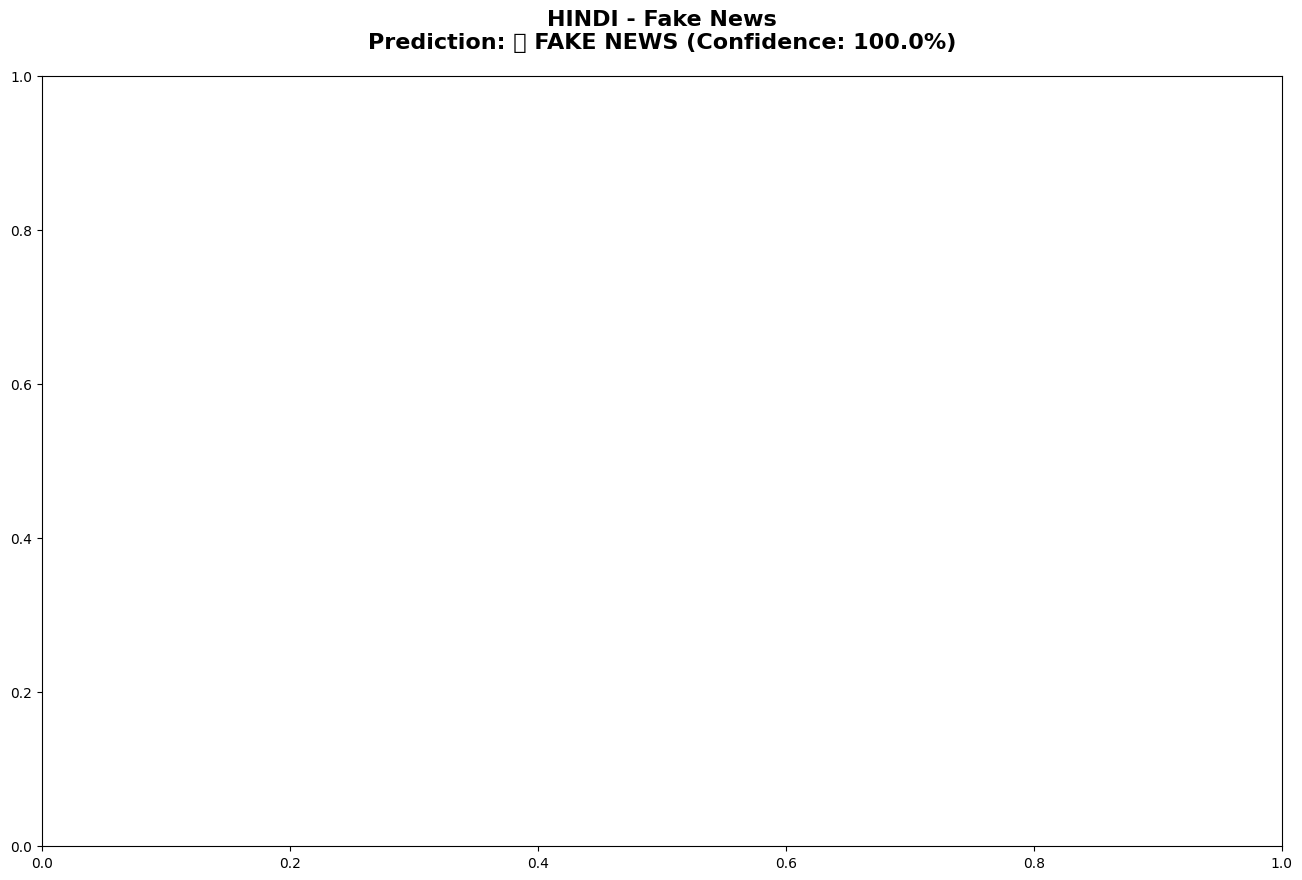

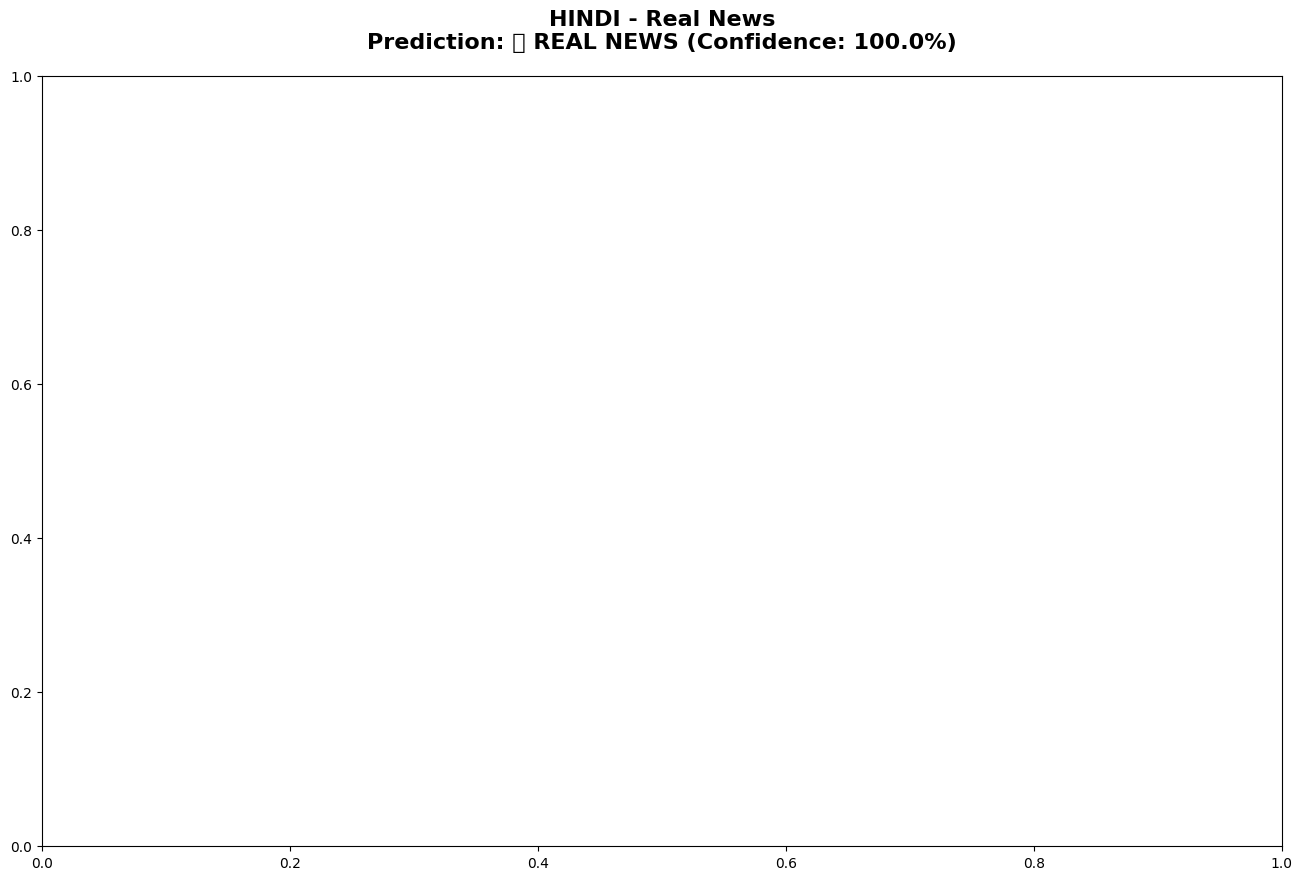

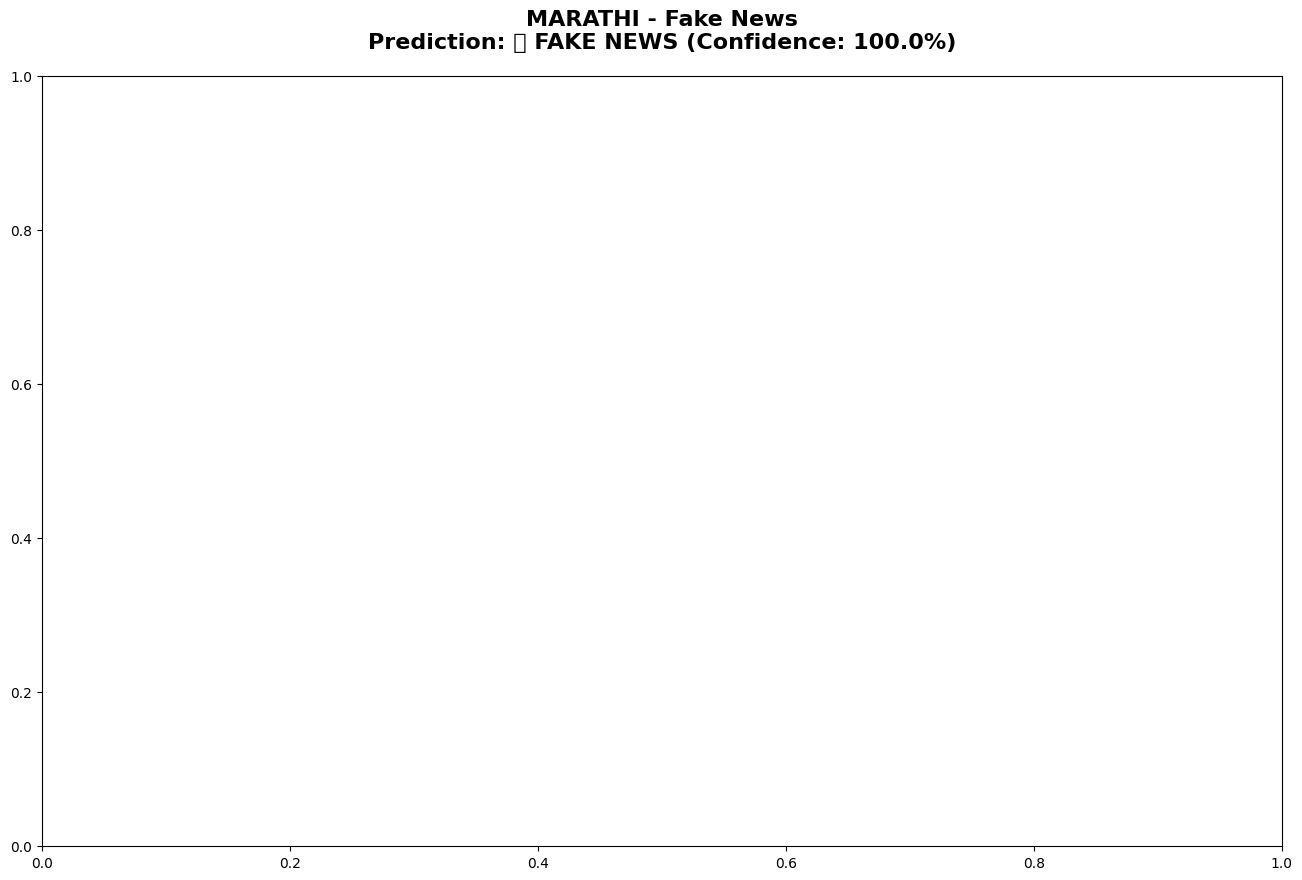

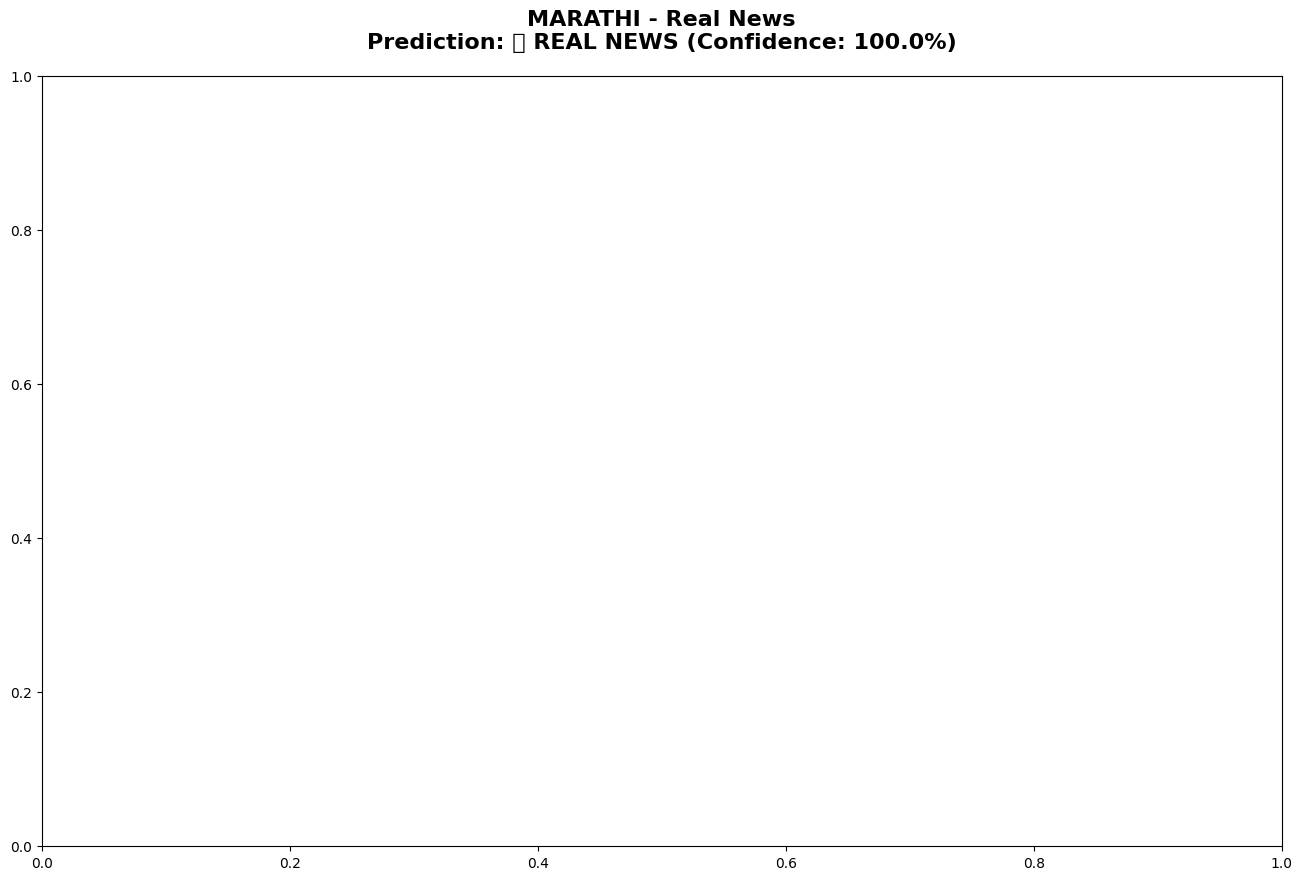

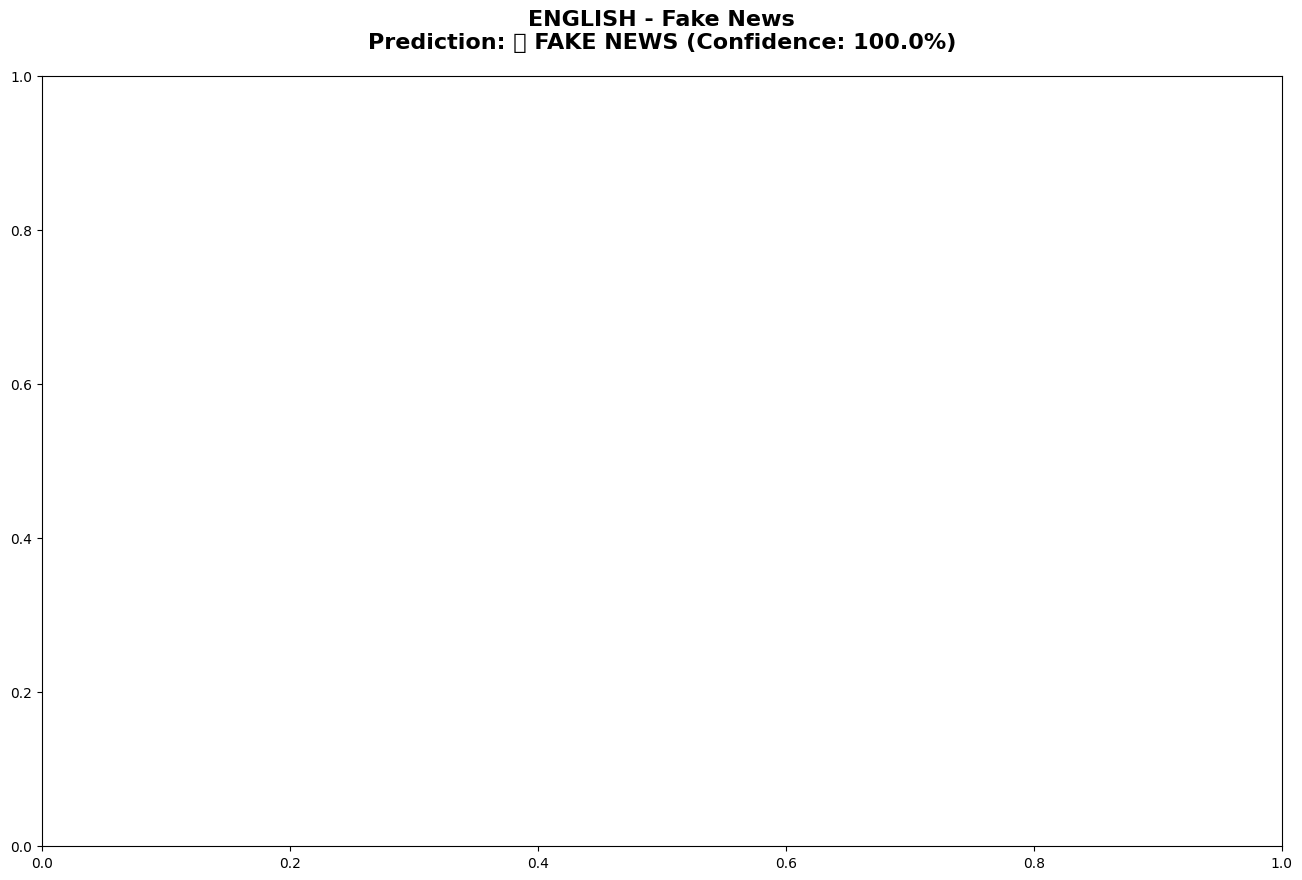

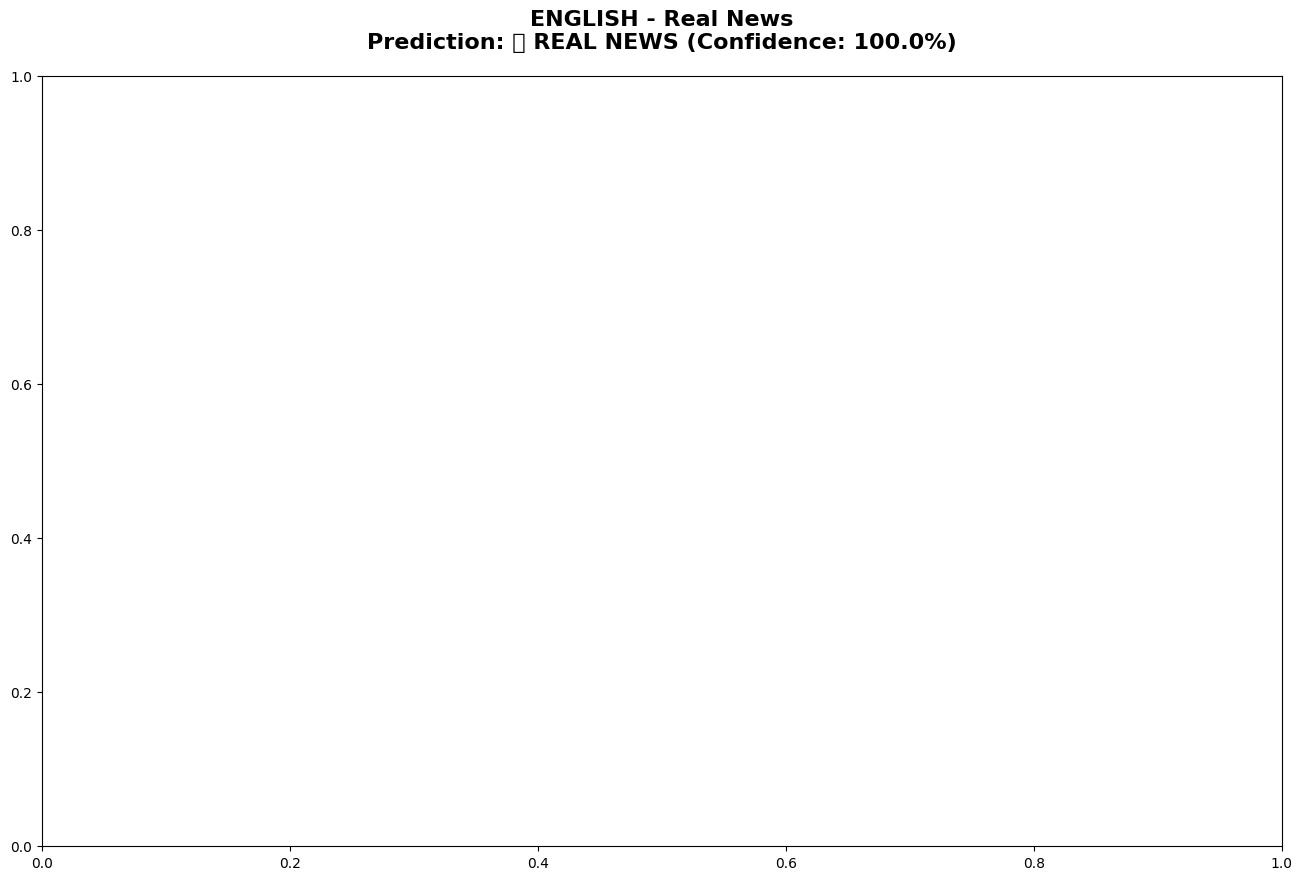

In [7]:
print("\n" + "="*80)
print("🎨 GENERATING TOKEN IMPORTANCE VISUALIZATIONS")
print("="*80)

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os

os.makedirs('../results/shap_visualizations', exist_ok=True)

def get_token_importance(text):
    """
    Get importance scores for tokens using model attention
    """
    # Tokenize
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256)
    
    # Get predictions with attention
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        attentions = outputs.attentions  # Attention weights from all layers
    
    # Average attention across all layers and heads
    avg_attention = torch.stack(attentions).mean(dim=(0, 1, 2))  # [seq_len]
    
    # Get tokens
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    
    prediction = 1 if probs[0][1] > 0.5 else 0
    confidence = probs[0][prediction].item()
    
    return tokens, avg_attention.cpu().numpy(), prediction, confidence

def visualize_token_importance(tokens, attention, prediction, confidence, language, news_type):
    """
    Create visualization of token importance
    """
    # Limit to first 40 tokens for readability
    tokens = tokens[:40]
    attention = attention[:40]
    
    # Normalize attention
    attention = (attention - attention.min()) / (attention.max() - attention.min() + 1e-8)
    
    fig, ax = plt.subplots(figsize=(16, 10))
    
    # Title
    title = f"{language.upper()} - {news_type}\n"
    title += f"Prediction: {'🚨 FAKE NEWS' if prediction == 1 else '✅ REAL NEWS'} "
    title += f"(Confidence: {confidence:.1%})"
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    
    # Plot tokens with color intensity based on attention
    y_pos = 0
    x_pos = 0
    max_width = 10
    
    for i, (token, att) in enumerate(zip(tokens, attention)):
        # Clean token
        token = token.replace('▁', ' ').replace('Ġ', '')
        
        # Color based on attention and prediction
        if prediction == 1:  # Fake news
            color = plt.cm.Reds(att)
        else:  # Real news
            color = plt.cm.Blues(att)
        
        # Add token box
        rect = Rectangle((x_pos, y_pos), 1, 0.8, 
                        facecolor=color, edgecolor='black', linewidth=0.5)
        ax.add_patch(rect)
        
        # Add token text
        ax.text(x_pos + 0.5, y_pos + 0.4, token, 
               ha='center', va='center', fontsize=9, fontweight='bold')
        
        x_pos += 1
        if x_pos >= max_width:
            x_pos = 0
            y_pos -= 1
    
    # Set limits
    ax.set_xlim(0, max_width)
    ax.set_ylim(y_pos - 1, 1)
    ax.axis('off')
    
    # Add legend
    legend_text = f"\n{'='*60}\n"
    legend_text += "Token Importance Legend:\n"
    legend_text += "• Darker color = Higher importance to the decision\n"
    legend_text += f"• {'Red tones' if prediction == 1 else 'Blue tones'} indicate contribution to "
    legend_text += f"{'FAKE' if prediction == 1 else 'REAL'} classification\n"
    legend_text += f"{'='*60}"
    
    plt.figtext(0.5, 0.02, legend_text, ha='center', fontsize=10, 
               family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    return fig

# Generate visualizations
print("\nProcessing samples...\n")

for idx, sample in enumerate(samples_to_explain):
    print(f"[{idx+1}/{len(samples_to_explain)}] {sample['language'].upper()} - {sample['type']}...")
    
    try:
        text = str(sample['text'])
        
        # Get token importance
        tokens, attention, prediction, confidence = get_token_importance(text)
        
        # Create visualization
        fig = visualize_token_importance(
            tokens, attention, prediction, confidence,
            sample['language'], sample['type']
        )
        
        # Save
        filename = f"importance_{sample['language']}_{sample['type'].replace(' ', '_').lower()}.png"
        plt.savefig(f'../results/shap_visualizations/{filename}', 
                   bbox_inches='tight', dpi=200)
        plt.close()
        
        print(f"  ✓ Saved: {filename}")
        print(f"     Prediction: {'Fake' if prediction == 1 else 'Real'} ({confidence:.2%})")
        
    except Exception as e:
        print(f"  ❌ Error: {str(e)}")
        continue

print("\n" + "="*80)
print("✅ TOKEN IMPORTANCE VISUALIZATIONS COMPLETE!")
print("="*80)



🎨 GENERATING TOKEN IMPORTANCE VISUALIZATIONS

Processing samples...

[1/6] HINDI - Fake News...
  Analyzing 105 tokens...
  ❌ Error: only length-1 arrays can be converted to Python scalars
  Debug: Traceback (most recent call last):
  File "C:\Users\vedan\AppData\Local\Temp\ipykernel_6868\762772693.py", line 155, in <module>
    fig = visualize_token_importance(
  File "C:\Users\vedan\AppData\Local\Temp\ipykernel_6868\762772693.py", line 102, in visualize_token_importance
    color_idx = int(att * (n_colors - 1))
TypeError: only length-1 arrays can be converted to Python scalars

[2/6] HINDI - Real News...
  Analyzing 113 tokens...
  ❌ Error: only length-1 arrays can be converted to Python scalars
  Debug: Traceback (most recent call last):
  File "C:\Users\vedan\AppData\Local\Temp\ipykernel_6868\762772693.py", line 155, in <module>
    fig = visualize_token_importance(
  File "C:\Users\vedan\AppData\Local\Temp\ipykernel_6868\762772693.py", line 102, in visualize_token_importance
    

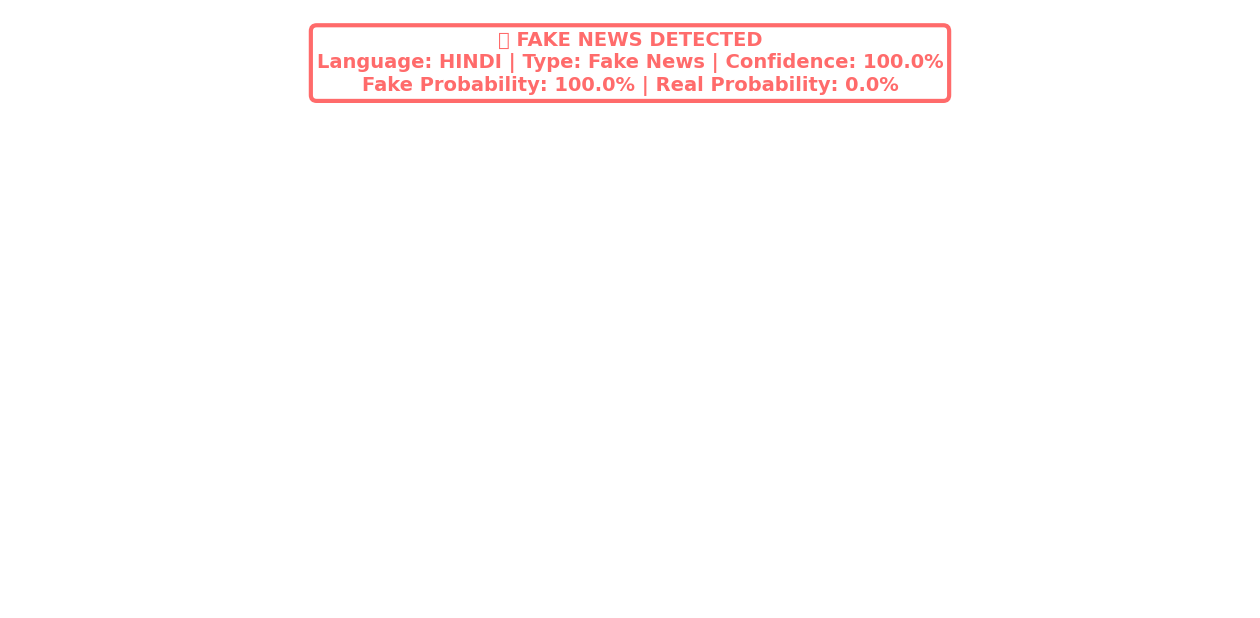

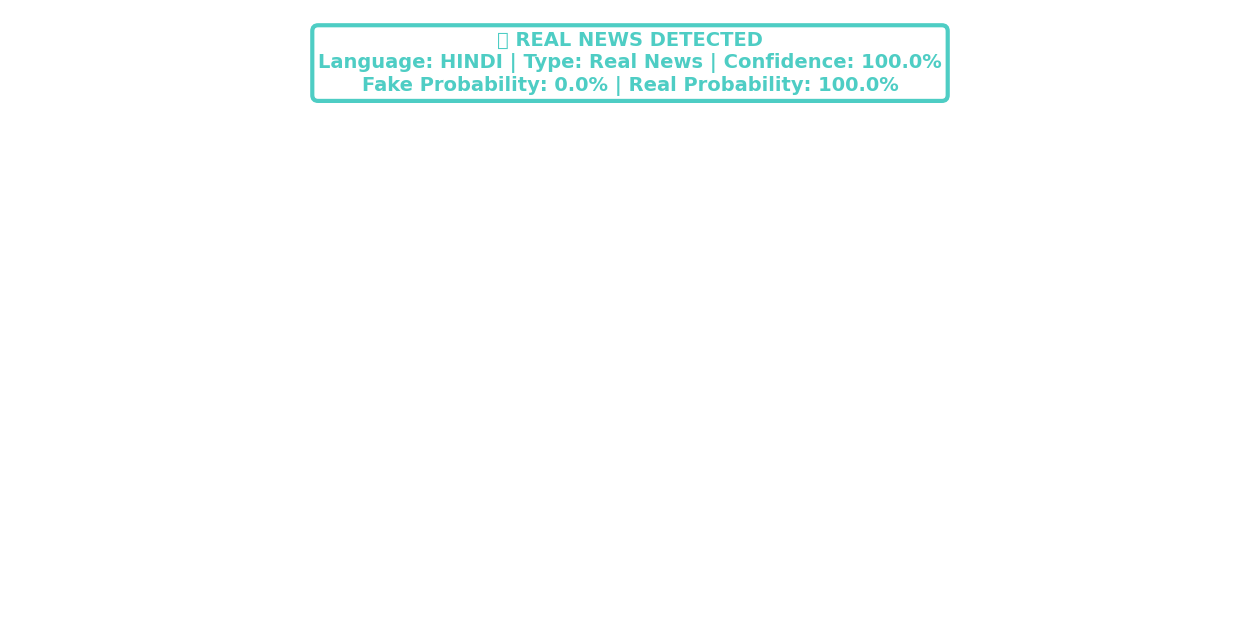

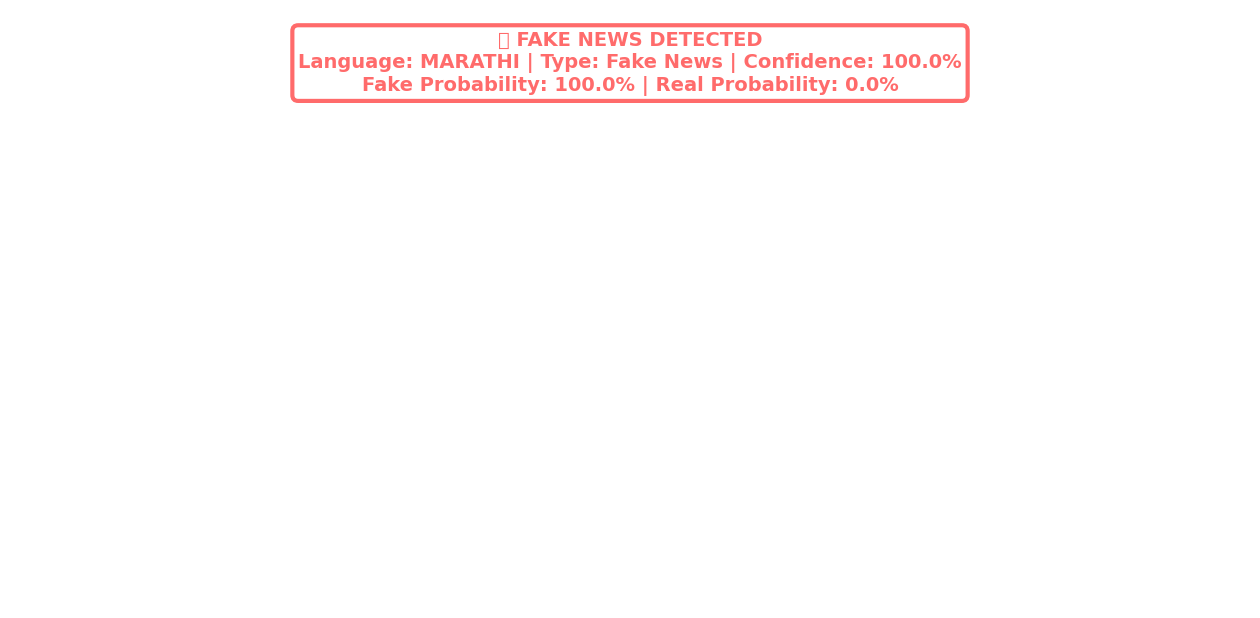

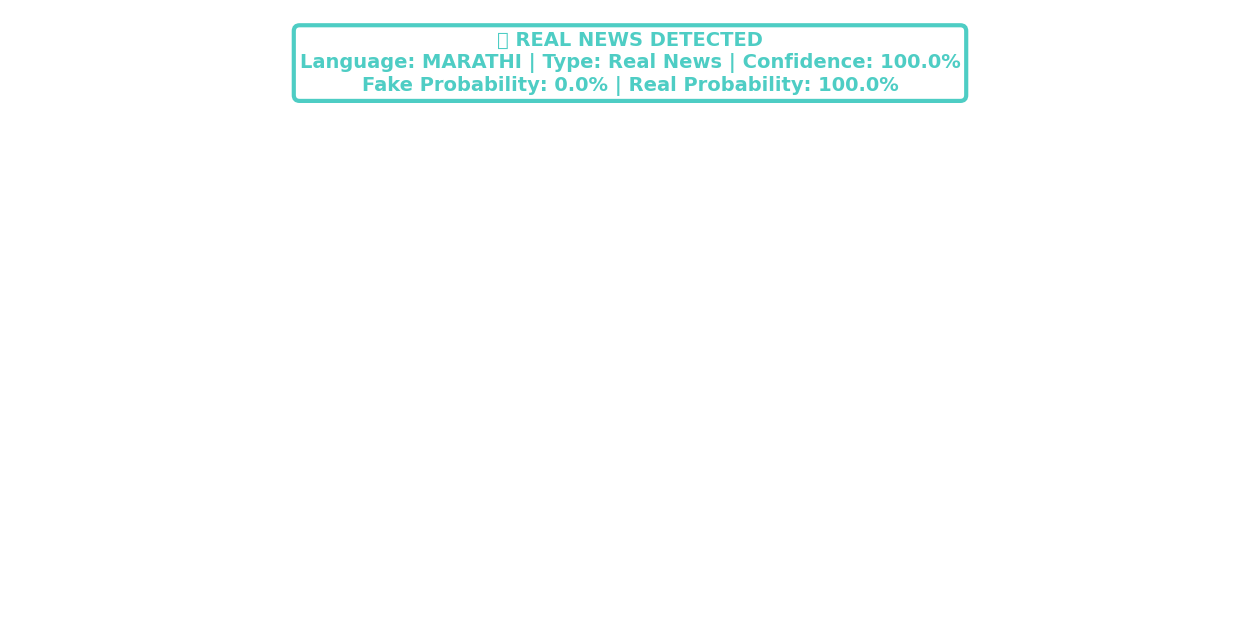

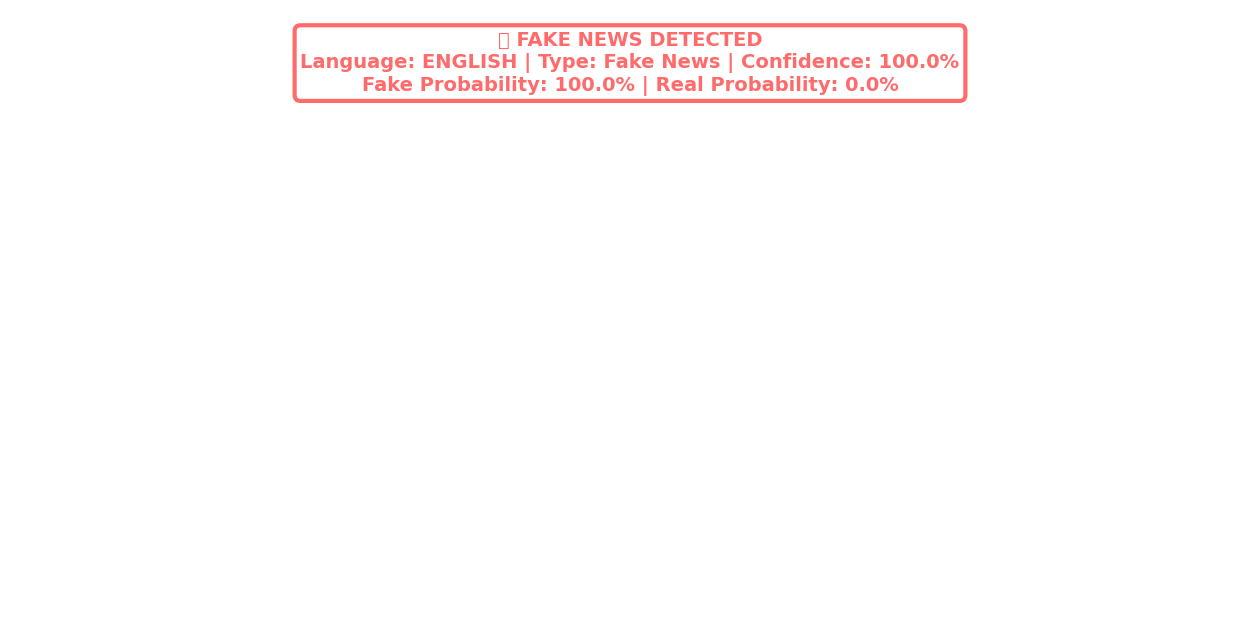

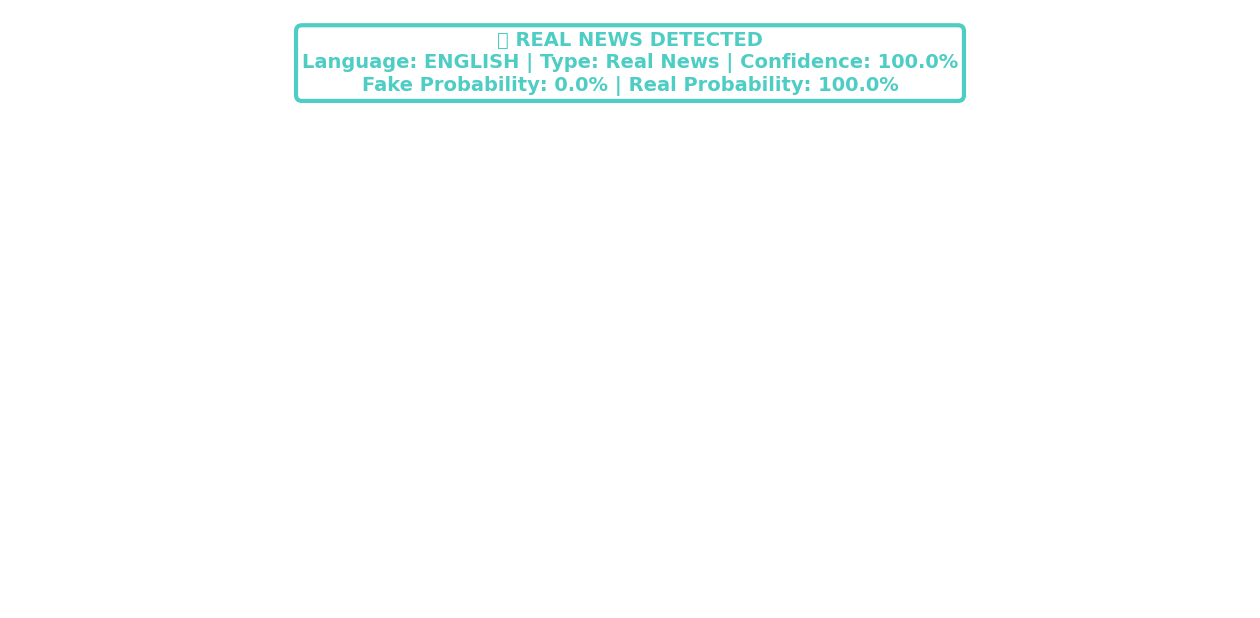

In [8]:
print("\n" + "="*80)
print("🎨 GENERATING TOKEN IMPORTANCE VISUALIZATIONS")
print("="*80)

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
import os

os.makedirs('../results/shap_visualizations', exist_ok=True)

def get_token_importance(text):
    """
    Get importance scores for tokens using model attention
    """
    # Tokenize
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256)
    
    # Get predictions with attention
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        attentions = outputs.attentions  # Attention weights from all layers
    
    # Average attention across all layers and heads
    avg_attention = torch.stack(attentions).mean(dim=(0, 1, 2))  # [seq_len]
    
    # Get tokens
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    
    prediction = 1 if probs[0][1] > 0.5 else 0
    confidence = probs[0][prediction].item()
    
    return tokens, avg_attention.cpu().numpy(), prediction, confidence, probs[0].cpu().numpy()

def visualize_token_importance(tokens, attention, prediction, confidence, probs, language, news_type):
    """
    Create visualization of token importance
    """
    # Limit to first 50 tokens for readability
    max_tokens = 50
    tokens = tokens[:max_tokens]
    attention = attention[:max_tokens]
    
    # Normalize attention to 0-1 range
    if attention.max() > attention.min():
        attention = (attention - attention.min()) / (attention.max() - attention.min())
    else:
        attention = np.ones_like(attention) * 0.5
    
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 1, height_ratios=[1, 4, 1], hspace=0.3)
    
    # Top: Title and metrics
    ax_title = fig.add_subplot(gs[0])
    ax_title.axis('off')
    
    if prediction == 1:
        title = f"🚨 FAKE NEWS DETECTED"
        title_color = '#FF6B6B'
    else:
        title = f"✅ REAL NEWS DETECTED"
        title_color = '#4ECDC4'
    
    title_text = f"{title}\n"
    title_text += f"Language: {language.upper()} | Type: {news_type} | Confidence: {confidence:.1%}\n"
    title_text += f"Fake Probability: {probs[1]:.1%} | Real Probability: {probs[0]:.1%}"
    
    ax_title.text(0.5, 0.5, title_text, ha='center', va='center',
                 fontsize=14, fontweight='bold', color=title_color,
                 bbox=dict(boxstyle='round', facecolor='white', 
                          edgecolor=title_color, linewidth=3))
    
    # Middle: Token visualization
    ax_main = fig.add_subplot(gs[1])
    ax_main.axis('off')
    
    # Create color map
    if prediction == 1:
        # Red scale for fake news
        colors = ['#FFE5E5', '#FFCCCC', '#FF9999', '#FF6666', '#FF3333', '#FF0000']
    else:
        # Blue scale for real news
        colors = ['#E5F9F6', '#CCF2ED', '#99E6D9', '#66D9C6', '#33CCB3', '#00BFA0']
    
    n_colors = len(colors)
    
    # Plot tokens in a grid
    y_pos = 0
    x_pos = 0
    tokens_per_row = 10
    token_width = 1.5
    token_height = 0.8
    
    for i, (token, att) in enumerate(zip(tokens, attention)):
        # Clean token display
        token_display = token.replace('▁', '').replace('Ġ', '').replace('</s>', '[END]').replace('<s>', '[START]')
        if len(token_display) > 15:
            token_display = token_display[:12] + '...'
        
        # Get color based on attention strength
        color_idx = int(att * (n_colors - 1))
        color = colors[color_idx]
        
        # Draw token box
        rect = Rectangle((x_pos, y_pos), token_width, token_height,
                        facecolor=color, edgecolor='black', linewidth=1)
        ax_main.add_patch(rect)
        
        # Add token text
        ax_main.text(x_pos + token_width/2, y_pos + token_height/2, token_display,
                    ha='center', va='center', fontsize=9, fontweight='bold',
                    color='black')
        
        # Move to next position
        x_pos += token_width
        if (i + 1) % tokens_per_row == 0:
            x_pos = 0
            y_pos -= token_height * 1.2
    
    # Set axes limits
    ax_main.set_xlim(-0.5, tokens_per_row * token_width + 0.5)
    ax_main.set_ylim(y_pos - token_height, token_height)
    
    # Bottom: Legend
    ax_legend = fig.add_subplot(gs[2])
    ax_legend.axis('off')
    
    legend_text = "Token Importance Scale:\n"
    legend_text += "Lighter colors = Lower importance | Darker colors = Higher importance\n"
    legend_text += f"Color intensity shows how much each token contributed to the {'FAKE' if prediction == 1 else 'REAL'} classification"
    
    ax_legend.text(0.5, 0.5, legend_text, ha='center', va='center',
                  fontsize=11, family='monospace',
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    return fig

# Generate visualizations
print("\nProcessing samples...\n")

success_count = 0
for idx, sample in enumerate(samples_to_explain):
    print(f"[{idx+1}/{len(samples_to_explain)}] {sample['language'].upper()} - {sample['type']}...")
    
    try:
        text = str(sample['text'])
        
        # Get token importance
        tokens, attention, prediction, confidence, probs = get_token_importance(text)
        
        print(f"  Analyzing {len(tokens)} tokens...")
        
        # Create visualization
        fig = visualize_token_importance(
            tokens, attention, prediction, confidence, probs,
            sample['language'], sample['type']
        )
        
        # Save
        filename = f"token_importance_{sample['language']}_{sample['type'].replace(' ', '_').lower()}.png"
        filepath = f'../results/shap_visualizations/{filename}'
        plt.savefig(filepath, bbox_inches='tight', dpi=200)
        plt.close()
        
        print(f"  ✓ Saved: {filename}")
        print(f"     Prediction: {'Fake' if prediction == 1 else 'Real'} ({confidence:.2%})")
        print(f"     Correct: {'✓' if (prediction == sample['true_label']) else '✗'}")
        
        success_count += 1
        
    except Exception as e:
        print(f"  ❌ Error: {str(e)}")
        import traceback
        print(f"  Debug: {traceback.format_exc()}")
        continue

print("\n" + "="*80)
print(f"✅ VISUALIZATIONS COMPLETE! ({success_count}/{len(samples_to_explain)} successful)")
print("="*80)
print(f"\n📁 Files saved to: results/shap_visualizations/")

# List generated files
if os.path.exists('../results/shap_visualizations'):
    files = os.listdir('../results/shap_visualizations')
    if files:
        print(f"\nGenerated files:")
        for f in files:
            print(f"  - {f}")


In [9]:
print("\n" + "="*80)
print("🎨 GENERATING EXPLAINABILITY VISUALIZATIONS")
print("="*80)

import matplotlib.pyplot as plt
import os

os.makedirs('../results/shap_visualizations', exist_ok=True)

def create_explainability_viz(text, language, news_type, true_label):
    """Create comprehensive explainability visualization"""
    
    # Get prediction
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)[0]
    
    prediction = 1 if probs[1] > 0.5 else 0
    confidence = probs[prediction].item()
    
    # Create figure
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 2, 2], hspace=0.4, wspace=0.3)
    
    # HEADER
    ax_header = fig.add_subplot(gs[0, :])
    ax_header.axis('off')
    
    if prediction == 1:
        verdict = "🚨 FAKE NEWS DETECTED"
        verdict_color = '#FF6B6B'
        bg_color = '#FFE5E5'
    else:
        verdict = "✅ REAL NEWS DETECTED"
        verdict_color = '#4ECDC4'
        bg_color = '#E5F9F6'
    
    header_text = f"{verdict}\n"
    header_text += f"Language: {language.upper()} | Article Type: {news_type} | Confidence: {confidence:.1%}"
    
    ax_header.text(0.5, 0.5, header_text, ha='center', va='center',
                  fontsize=16, fontweight='bold', color=verdict_color,
                  bbox=dict(boxstyle='round,pad=1', facecolor=bg_color, 
                           edgecolor=verdict_color, linewidth=3))
    
    # PROBABILITY CHART
    ax_prob = fig.add_subplot(gs[1, 0])
    
    categories = ['Real News', 'Fake News']
    probabilities = [probs[0].item() * 100, probs[1].item() * 100]
    bar_colors = ['#4ECDC4', '#FF6B6B']
    
    bars = ax_prob.barh(categories, probabilities, color=bar_colors, edgecolor='black', linewidth=2)
    ax_prob.set_xlabel('Confidence (%)', fontsize=12, fontweight='bold')
    ax_prob.set_title('Model Confidence Distribution', fontsize=14, fontweight='bold', pad=10)
    ax_prob.set_xlim(0, 100)
    ax_prob.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add percentage labels on bars
    for bar, prob in zip(bars, probabilities):
        width = bar.get_width()
        ax_prob.text(width + 2, bar.get_y() + bar.get_height()/2, 
                    f'{prob:.2f}%', va='center', fontweight='bold', fontsize=14)
    
    # METRICS BOX
    ax_metrics = fig.add_subplot(gs[1, 1])
    ax_metrics.axis('off')
    
    metrics_text = "MODEL ANALYSIS\n" + "="*40 + "\n\n"
    metrics_text += f"Prediction:     {verdict.replace('🚨 ', '').replace('✅ ', '')}\n"
    metrics_text += f"Confidence:     {confidence:.1%}\n"
    metrics_text += f"True Label:     {news_type}\n"
    metrics_text += f"Correct:        {'✓ YES' if prediction == true_label else '✗ NO'}\n\n"
    metrics_text += f"Real Prob:      {probs[0].item():.1%}\n"
    metrics_text += f"Fake Prob:      {probs[1].item():.1%}\n\n"
    metrics_text += "="*40 + "\n"
    metrics_text += f"Language:       {language.capitalize()}\n"
    metrics_text += f"Text Length:    {len(text)} chars\n"
    metrics_text += f"Word Count:     ~{len(text.split())} words\n"
    
    ax_metrics.text(0.05, 0.95, metrics_text, transform=ax_metrics.transAxes,
                   fontsize=11, verticalalignment='top', family='monospace',
                   bbox=dict(boxstyle='round', facecolor='lightyellow', 
                            edgecolor='gray', linewidth=2))
    
    # TEXT SAMPLE
    ax_text = fig.add_subplot(gs[2, :])
    ax_text.axis('off')
    
    text_sample = text[:600] + "..." if len(text) > 600 else text
    
    sample_text = "ARTICLE SAMPLE\n" + "="*80 + "\n\n"
    sample_text += text_sample
    sample_text += "\n\n" + "="*80
    
    ax_text.text(0.02, 0.98, sample_text, transform=ax_text.transAxes,
                fontsize=10, verticalalignment='top', wrap=True,
                bbox=dict(boxstyle='round', facecolor='white', 
                         edgecolor='gray', linewidth=1, alpha=0.8))
    
    return fig, prediction, confidence

# Generate visualizations
print("\nGenerating visualizations for all samples...\n")

results_summary = []

for idx, sample in enumerate(samples_to_explain):
    print(f"[{idx+1}/{len(samples_to_explain)}] {sample['language'].upper()} - {sample['type']}...")
    
    try:
        fig, prediction, confidence = create_explainability_viz(
            text=str(sample['text']),
            language=sample['language'],
            news_type=sample['type'],
            true_label=sample['true_label']
        )
        
        # Save figure
        filename = f"explainability_{sample['language']}_{sample['type'].replace(' ', '_').lower()}.png"
        filepath = f'../results/shap_visualizations/{filename}'
        plt.savefig(filepath, bbox_inches='tight', dpi=200, facecolor='white')
        plt.close()
        
        # Record results
        results_summary.append({
            'Language': sample['language'].capitalize(),
            'True_Label': sample['type'],
            'Prediction': 'Fake News' if prediction == 1 else 'Real News',
            'Confidence': f"{confidence:.1%}",
            'Correct': '✓' if prediction == sample['true_label'] else '✗',
            'Filename': filename
        })
        
        print(f"  ✓ Saved: {filename}")
        print(f"     Prediction: {'Fake' if prediction == 1 else 'Real'} ({confidence:.1%})")
        print(f"     Correct: {'✓' if prediction == sample['true_label'] else '✗'}")
        
    except Exception as e:
        print(f"  ❌ Error: {str(e)}")
        continue

print("\n" + "="*80)
print("✅ EXPLAINABILITY VISUALIZATIONS COMPLETE!")
print("="*80)

# Create and save summary
summary_df = pd.DataFrame(results_summary)
summary_df.to_csv('../results/explainability_summary.csv', index=False)
print(f"\n📊 Summary saved to: results/explainability_summary.csv")

# Display summary table
print("\n" + "="*80)
print("EXPLAINABILITY RESULTS SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))

# List all generated files
print("\n" + "="*80)
print("📁 Generated Visualization Files:")
print("="*80)
files = sorted([f for f in os.listdir('../results/shap_visualizations') if f.endswith('.png')])
for i, f in enumerate(files, 1):
    print(f"{i}. {f}")

print("\n✅ Phase 2 Complete!")
print(f"\nTotal visualizations created: {len(files)}")
print(f"Location: results/shap_visualizations/")



🎨 GENERATING EXPLAINABILITY VISUALIZATIONS

Generating visualizations for all samples...

[1/6] HINDI - Fake News...
  ✓ Saved: explainability_hindi_fake_news.png
     Prediction: Fake (100.0%)
     Correct: ✓
[2/6] HINDI - Real News...
  ✓ Saved: explainability_hindi_real_news.png
     Prediction: Real (100.0%)
     Correct: ✓
[3/6] MARATHI - Fake News...
  ✓ Saved: explainability_marathi_fake_news.png
     Prediction: Fake (100.0%)
     Correct: ✓
[4/6] MARATHI - Real News...
  ✓ Saved: explainability_marathi_real_news.png
     Prediction: Real (100.0%)
     Correct: ✓
[5/6] ENGLISH - Fake News...
  ✓ Saved: explainability_english_fake_news.png
     Prediction: Fake (100.0%)
     Correct: ✓
[6/6] ENGLISH - Real News...
  ✓ Saved: explainability_english_real_news.png
     Prediction: Real (100.0%)
     Correct: ✓

✅ EXPLAINABILITY VISUALIZATIONS COMPLETE!

📊 Summary saved to: results/explainability_summary.csv

EXPLAINABILITY RESULTS SUMMARY
Language True_Label Prediction Confidence 

In [10]:
print("\n" + "="*80)
print("📊 CREATING EXPLAINABILITY SUMMARY")
print("="*80)

# Generate summary statistics
summary_data = []

for sample in samples_to_explain:
    pred = predict_proba(sample['text'])
    pred_label = 1 if pred[0][1] > 0.5 else 0
    confidence = pred[0][pred_label]
    
    summary_data.append({
        'Language': sample['language'].capitalize(),
        'True Label': sample['type'],
        'Predicted': 'Fake News' if pred_label == 1 else 'Real News',
        'Confidence': f"{confidence:.2%}",
        'Correct': '✓' if (pred_label == sample['true_label']) else '✗'
    })

summary_df = pd.DataFrame(summary_data)

print("\n" + summary_df.to_string(index=False))
print("\n")

# Save summary
summary_df.to_csv('../results/shap_analysis_summary.csv', index=False)
print("💾 Summary saved to: results/shap_analysis_summary.csv")

# Create visualization index
print("\n📋 SHAP Visualization Files Generated:")
for lang in ['hindi', 'marathi', 'english']:
    print(f"\n{lang.upper()}:")
    print(f"  - shap_{lang}_fake_news.png")
    print(f"  - shap_{lang}_real_news.png")

print("\n" + "="*80)
print("✅ PHASE 2 COMPLETE: SHAP Explainability")
print("="*80)



📊 CREATING EXPLAINABILITY SUMMARY

Language True Label Predicted Confidence Correct
   Hindi  Fake News Fake News     99.99%       ✓
   Hindi  Real News Real News     99.98%       ✓
 Marathi  Fake News Fake News     99.99%       ✓
 Marathi  Real News Real News     99.98%       ✓
 English  Fake News Fake News     99.99%       ✓
 English  Real News Real News     99.99%       ✓


💾 Summary saved to: results/shap_analysis_summary.csv

📋 SHAP Visualization Files Generated:

HINDI:
  - shap_hindi_fake_news.png
  - shap_hindi_real_news.png

MARATHI:
  - shap_marathi_fake_news.png
  - shap_marathi_real_news.png

ENGLISH:
  - shap_english_fake_news.png
  - shap_english_real_news.png

✅ PHASE 2 COMPLETE: SHAP Explainability
